# Data Engineering

In [1754]:
import missingno as msno
import pandas as pd
from numpy import nan, sin, cos, pi
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline

In [1755]:
data = pd.read_csv("../docs/dataset_DT.csv")
data.dtypes

age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day          float64
month         object
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome      object
y             object
dtype: object

In [1756]:
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].replace([nan, "", " ", "unknown"], pd.NA)

data["pdays"] = data["pdays"].replace([-1], [float(nan)])


<Axes: >

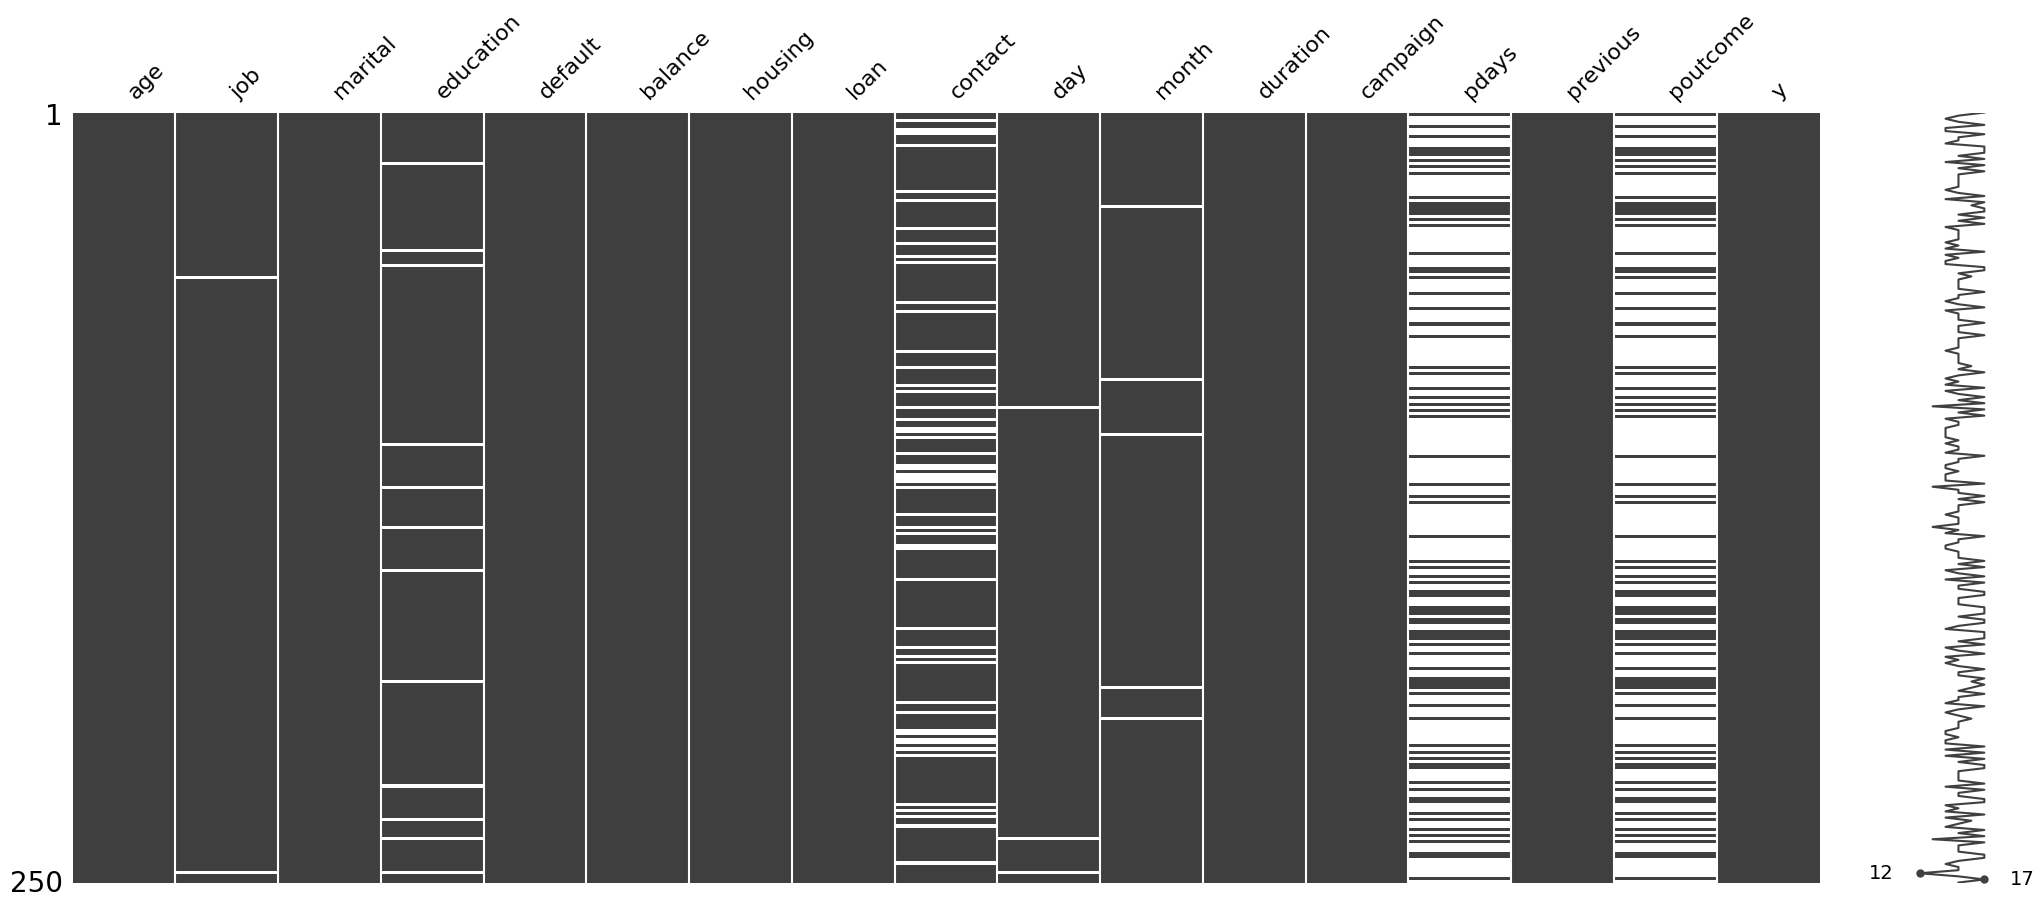

In [1757]:
msno.matrix(data.sample(250))

<Axes: >

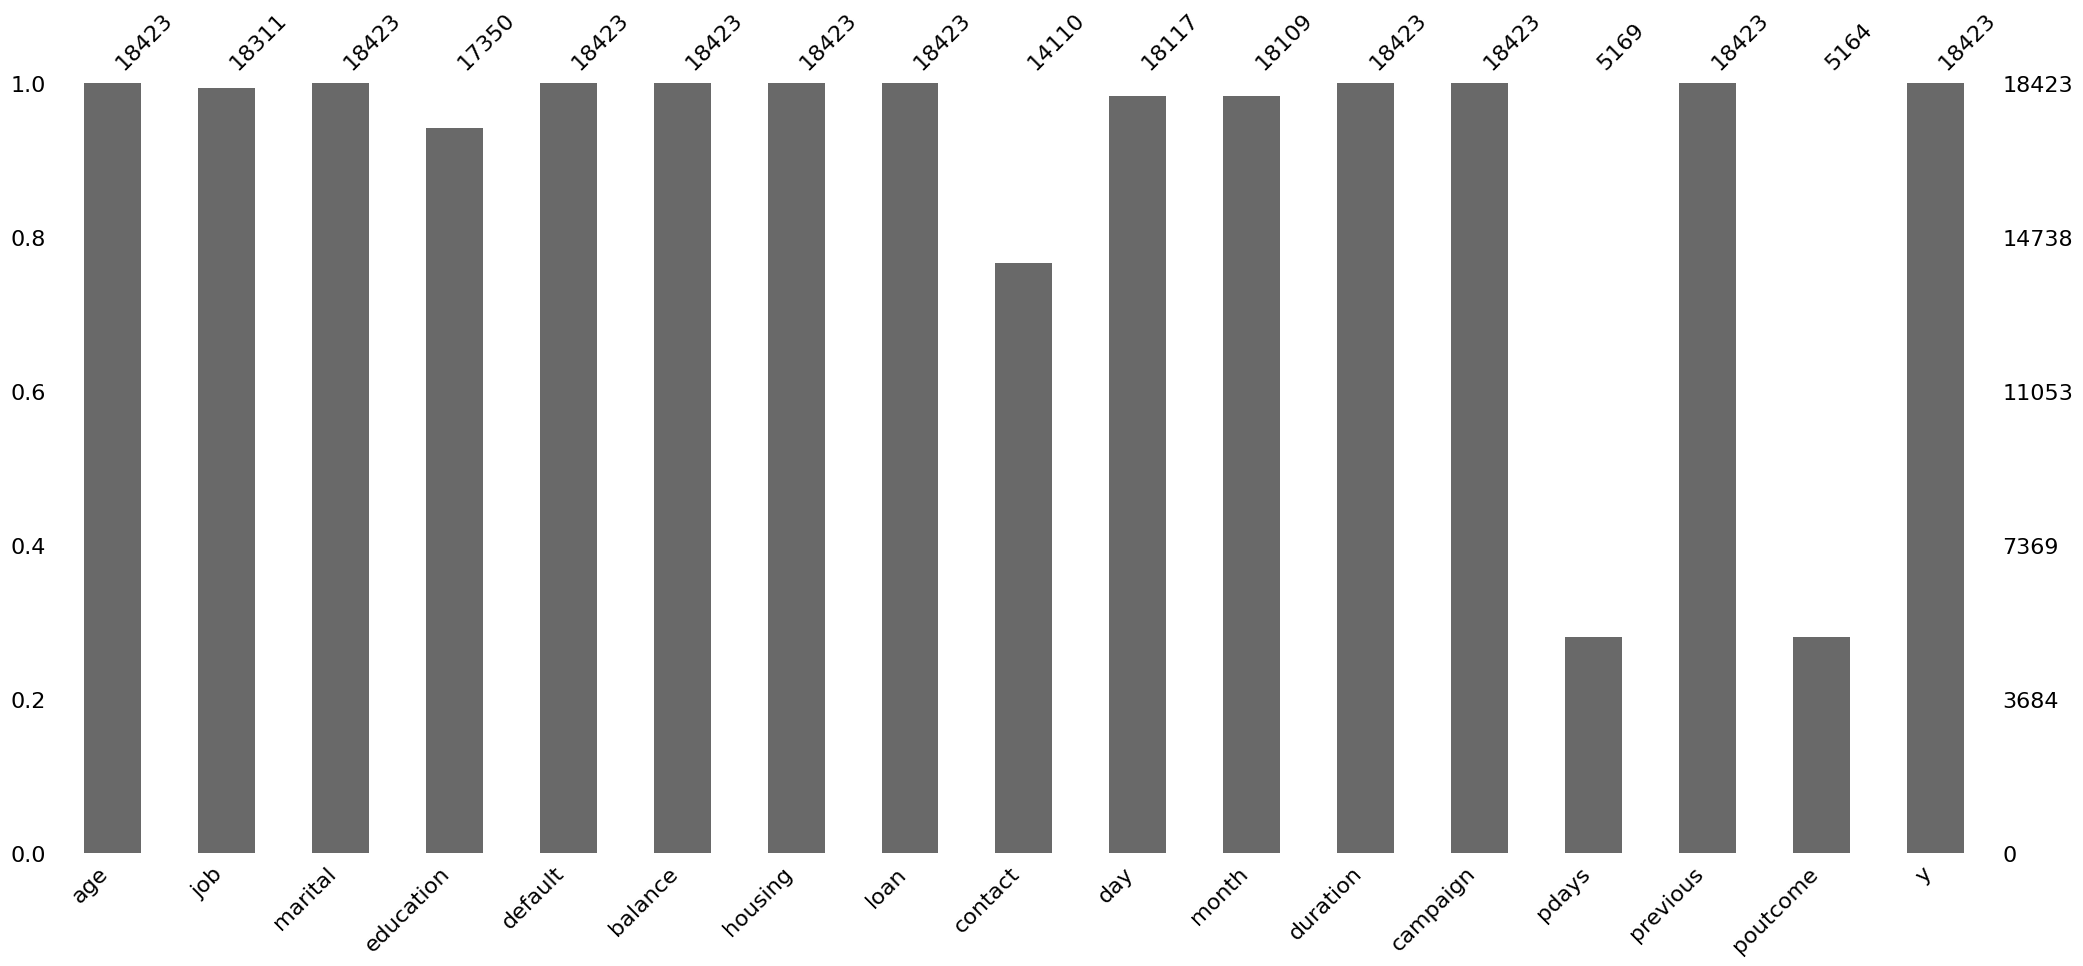

In [1758]:
msno.bar(data)

<Axes: >

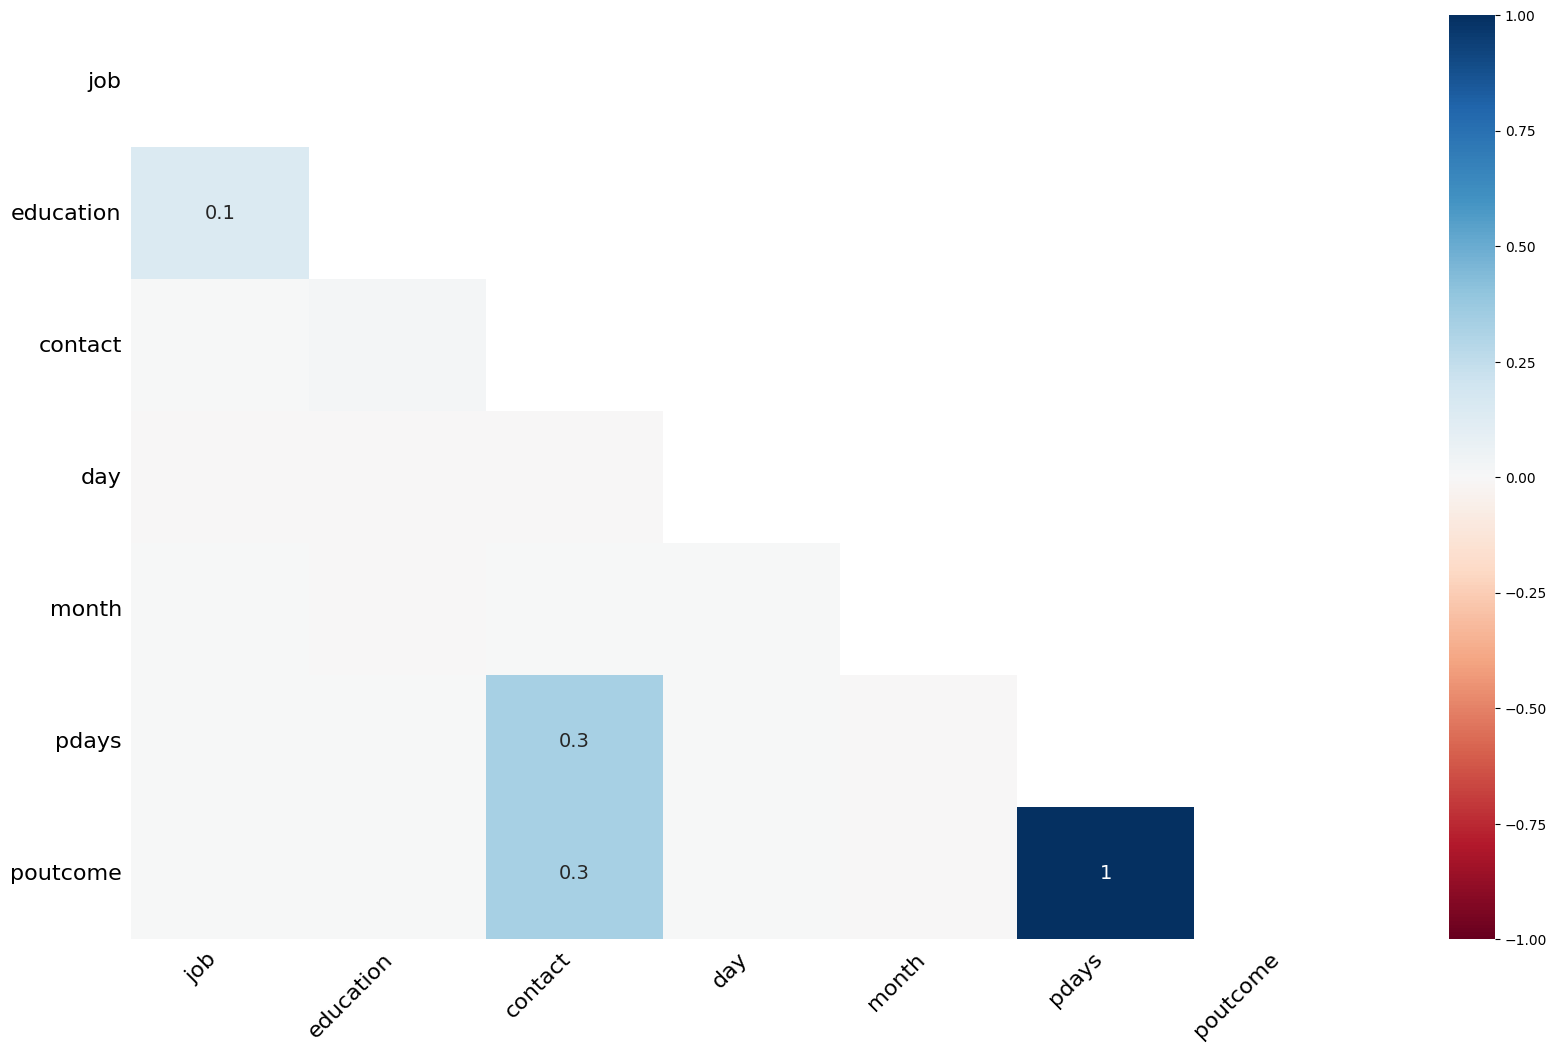

In [1759]:
msno.heatmap(data)

<Axes: >

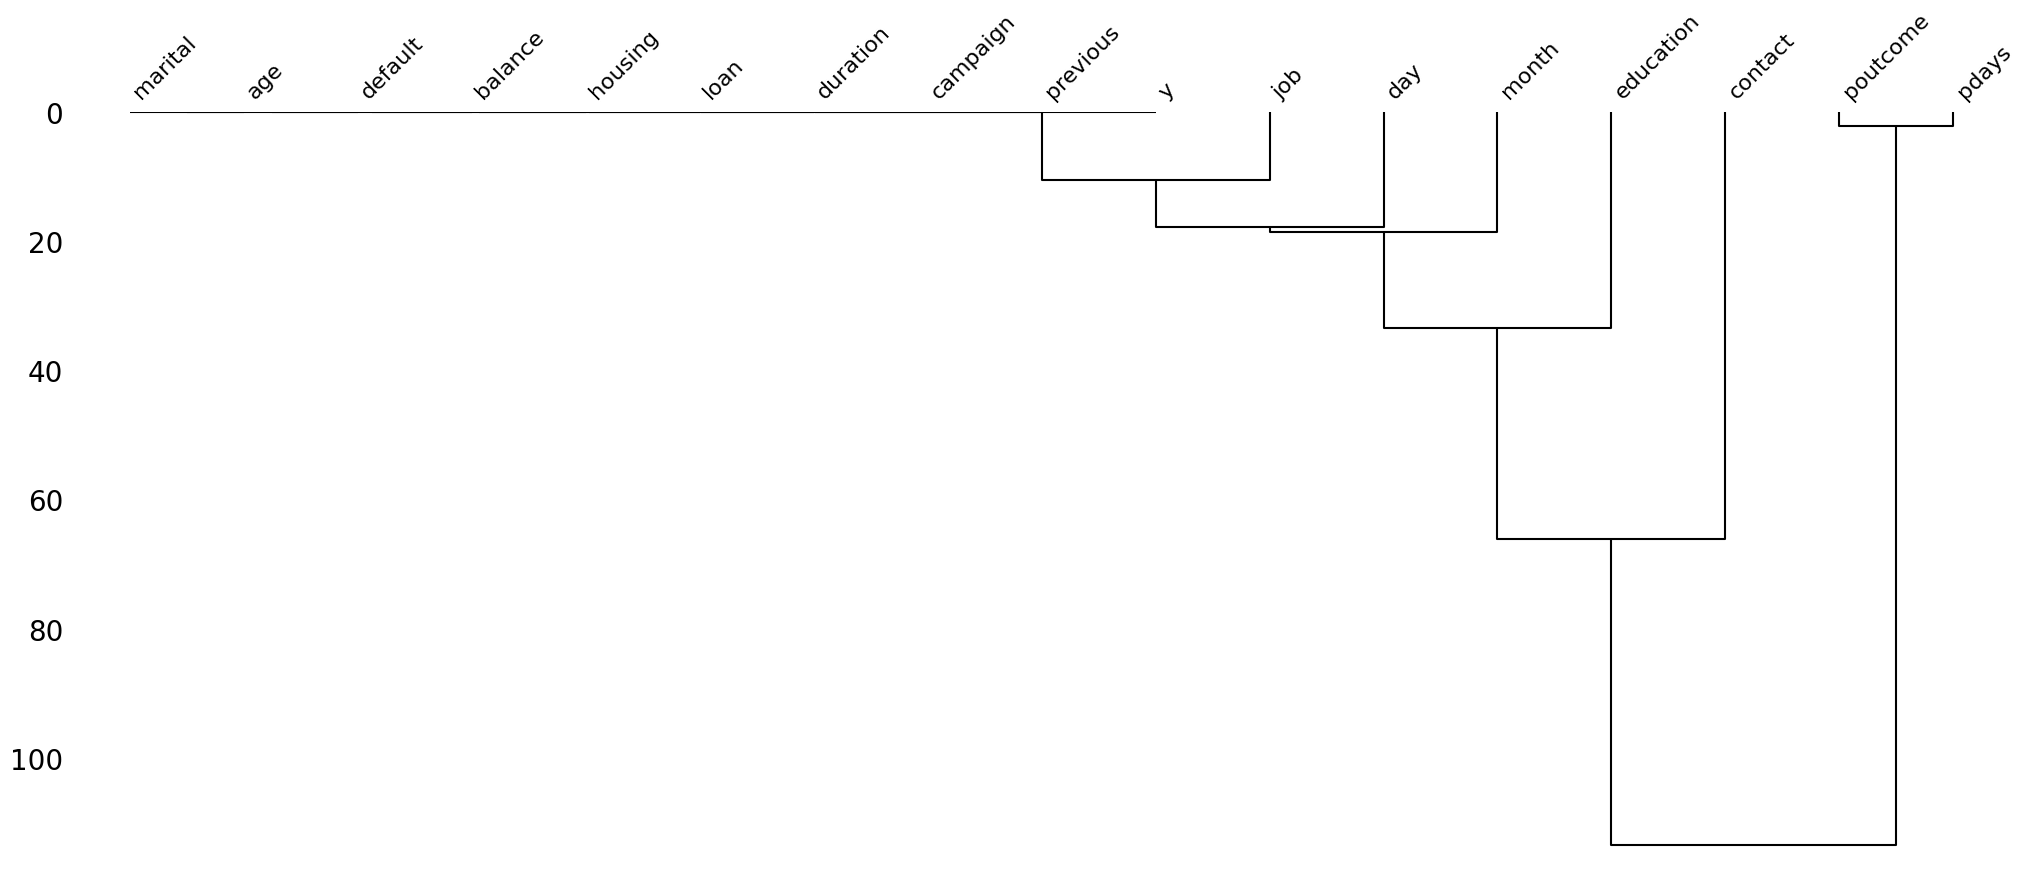

In [1760]:
msno.dendrogram(data)

In [1761]:
percent_missing = data.isnull().sum() * 100 / len(data)

print(percent_missing)

age           0.000000
job           0.607936
marital       0.000000
education     5.824241
default       0.000000
balance       0.000000
housing       0.000000
loan          0.000000
contact      23.410954
day           1.660967
month         1.704391
duration      0.000000
campaign      0.000000
pdays        71.942680
previous      0.000000
poutcome     71.969820
y             0.000000
dtype: float64


In [1762]:
data.dropna(subset=["job"], inplace=True)

In [1763]:
# Drop records where poutcome is null and pdays is not. This is likely a sampling error.
data = data[~((data["poutcome"].isnull()) & (data["pdays"].notnull()))]

In [1764]:
data["education"] = data["education"].fillna("unknown")

In [1765]:
# Creating day to int from float
data["day"] = pd.to_numeric(data["day"], errors="coerce").fillna(0).astype(int)
data["day"]

0         1
1         1
2         1
3         1
4         1
         ..
18418    30
18419    30
18420    30
18421    30
18422    30
Name: day, Length: 18306, dtype: int64

In [1766]:
# Define a function to handle day and month data, and add the year 2024
def create_date(row):
    """Creates a date from the 'day' and 'month' columns in a DataFrame row, assuming the year is 2024.

    The function handles potential errors in day and month values and returns NaT (Not a Time)
    if a valid date cannot be created.

    Args:
        row (pandas.Series): A row from a Pandas DataFrame containing 'day' and 'month' columns.

    Returns:
        pandas.Timestamp or pandas.NaT:
            - A pandas Timestamp representing the created date if successful.
            - NaT (Not a Time) if either 'day' or 'month' is missing or if there's an error
              converting the values to a date.
    """
    # Only create date if both day and month are available
    if pd.notna(row["day"]) and pd.notna(row["month"]):
        try:
            # Ensure that day is integer if possible
            day = int(row["day"])
            # Use the month from the row and assume 2024 as the year
            return pd.to_datetime(f'2024-{row["month"]}-{day}', format="%Y-%b-%d", errors="coerce")
        except Exception:
            return pd.NaT  # Return a NaT (Not a Time) if any error occurs
    else:
        return pd.NaT  # Return NaT if either day or month is missing


# Apply the function to each row
data["date"] = data.apply(create_date, axis=1)

# Fill forward the missing dates by propagating the previous non-null date
data["date"] = data["date"].ffill()

In [1767]:
data = data.drop(["day", "month"], axis=1)
data["day_of_week"] = data["date"].dt.day_of_week
data["month"] = data["date"].dt.month
data = data.drop("date", axis=1)

In [1768]:
# Sine and cosine transformation for months (1-12)
data["month_sin"] = sin(2 * pi * data["month"] / 12)
data["month_cos"] = cos(2 * pi * data["month"] / 12)

# Sine and cosine transformation for day of the week (0-6)
data["day_of_week_sin"] = sin(2 * pi * data["day_of_week"] / 7)
data["day_of_week_cos"] = cos(2 * pi * data["day_of_week"] / 7)

In [1769]:
data.head(25)

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,pdays,previous,poutcome,y,day_of_week,month,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,34.0,blue-collar,single,secondary,no,13408.0,no,no,cellular,647.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
1,49.0,management,divorced,tertiary,no,20727.0,no,no,cellular,285.0,...,132.0,2.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
2,32.0,services,single,tertiary,no,1743.0,yes,no,cellular,1156.0,...,261.0,3.0,other,no,0,4,0.866025,-0.5,0.0,1.0
3,46.0,management,divorced,tertiary,no,10469.0,yes,no,cellular,202.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
4,26.0,management,single,tertiary,no,7628.0,no,no,cellular,263.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
5,54.0,retired,married,secondary,no,1004.0,yes,no,cellular,479.0,...,307.0,1.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
6,32.0,technician,single,tertiary,no,392.0,yes,no,cellular,957.0,...,131.0,2.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
7,37.0,management,married,secondary,no,1180.0,yes,yes,cellular,786.0,...,135.0,1.0,other,no,0,4,0.866025,-0.5,0.0,1.0
8,33.0,admin.,single,secondary,no,285.0,yes,no,cellular,427.0,...,329.0,1.0,other,no,0,4,0.866025,-0.5,0.0,1.0
9,46.0,self-employed,divorced,tertiary,no,926.0,yes,no,cellular,463.0,...,133.0,3.0,failure,no,0,4,0.866025,-0.5,0.0,1.0


In [1770]:
# Define the custom order for education
custom_order = ["unknown", "primary", "secondary", "tertiary"]

# Create a mapping from each category to an integer based on the order
education_map = {category: idx for idx, category in enumerate(custom_order)}

# Apply the mapping to the column (including NaN handling)
data["education"] = data["education"].apply(
    lambda x: education_map[x] if x in education_map else None
)

In [1771]:
data["pdays"] = data["pdays"].fillna(-1)
data["poutcome"] = data["poutcome"].fillna("unknown")

In [1772]:
def one_hot_encode_column(df, column, treat_missing_as_category=False):
    """One-hot encodes a specified column in the DataFrame.

    Optionally, treats missing values (NaN) as a separate category.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to one-hot encode.
    treat_missing_as_category (bool): If True, treat NaN as a separate category.

    Returns:
    pd.DataFrame: A DataFrame with the one-hot encoded column.
    """
    # If missing values should be treated as a separate category, fill NaNs with a placeholder
    if treat_missing_as_category:
        df[column] = df[column].fillna("unknown")

    # One-hot encode the column
    df_encoded = pd.get_dummies(df, columns=[column], prefix=column)

    return df_encoded


data = one_hot_encode_column(data, "job")
data = one_hot_encode_column(data, "marital")
data = one_hot_encode_column(data, "default")
data = one_hot_encode_column(data, "housing")
data = one_hot_encode_column(data, "loan")
data = one_hot_encode_column(data, "contact", True)
data = one_hot_encode_column(data, "poutcome")

In [1773]:
# Apply the mapping to the column (including NaN handling)
data["y"] = data["y"].map({"yes": 1, "no": 0})

In [1774]:
data.to_csv("../docs/out.csv")

<Axes: >

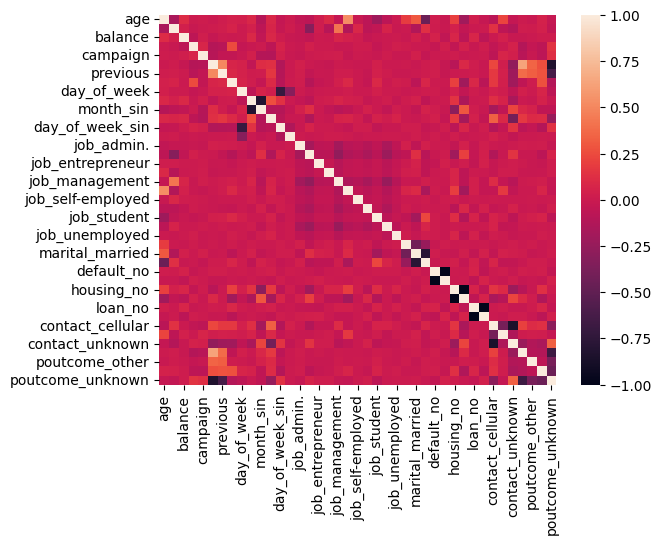

In [1775]:

sns.heatmap(data.corr())

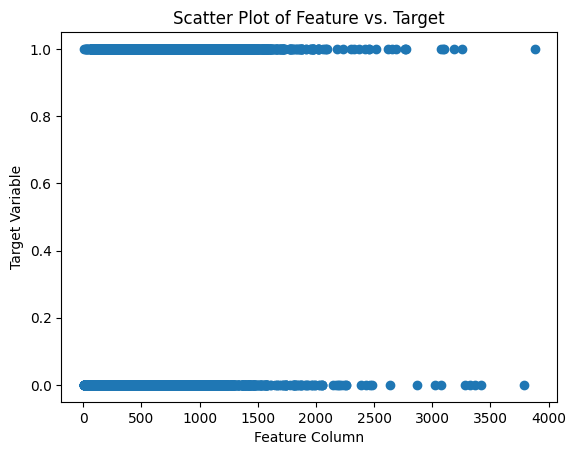

In [1776]:
import matplotlib.pyplot as plt

plt.scatter(data["duration"], data["y"])
plt.xlabel('Feature Column')
plt.ylabel('Target Variable')
plt.title('Scatter Plot of Feature vs. Target')
plt.show()

### Discretizing Duration

In [1777]:
# Number of bins (for equal interval clustering)
# num_bins = 5

# # Perform equal interval binning
# data["duration_bin"] = pd.cut(data["duration"], bins=num_bins, labels=False)

In [1778]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = data["duration"].values.reshape(-1, 1)

# Scale the feature using StandardScaler or MinMaxScaler
scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with k clusters (number of bins)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_scaled)

# Get the cluster labels (this will be the discretized version of the feature)
# data['discretized_duration'] = kmeans.labels_

# View the original continuous feature, scaled values, and discretized version
data['scaled_duration'] = X_scaled

In [1779]:
data = data.drop("duration", axis=1)

data.head(100)

,age,education,balance,campaign,pdays,previous,y,day_of_week,month,month_sin,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,scaled_duration
0,34.0,2,13408.0,2.0,-1.0,0.0,0,0,4,0.866025,...,True,False,True,False,False,False,False,False,True,0.726703
1,49.0,3,20727.0,3.0,132.0,2.0,0,0,4,0.866025,...,True,False,True,False,False,True,False,False,False,-0.392066
2,32.0,3,1743.0,1.0,261.0,3.0,0,0,4,0.866025,...,True,False,True,False,False,False,True,False,False,2.299780
3,46.0,3,10469.0,2.0,-1.0,0.0,0,0,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.648580
4,26.0,3,7628.0,1.0,-1.0,0.0,0,0,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,53.0,2,459.0,1.0,-1.0,0.0,1,4,4,0.866025,...,True,False,True,False,False,False,False,False,True,0.451647
97,54.0,3,118.0,1.0,-1.0,0.0,1,4,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.407519
98,54.0,2,2102.0,1.0,626.0,2.0,1,4,4,0.866025,...,True,False,True,False,False,True,False,False,False,0.417651
99,34.0,2,800.0,1.0,-1.0,0.0,1,4,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.827830


### Discretizing Balance

In [1780]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # Assuming 'df' is your DataFrame and 'features' is a list of feature column names
# X = data["balance"].values.reshape(-1, 1)

# # Scale the feature using StandardScaler or MinMaxScaler
# scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
# X_scaled = scaler.fit_transform(X)

# # Perform K-means clustering with k clusters (number of bins)
# kmeans = KMeans(n_clusters=3, random_state=0)
# kmeans.fit(X_scaled)

# # Get the cluster labels (this will be the discretized version of the feature)
# data['discretized_balance'] = kmeans.labels_

# # View the original continuous feature, scaled values, and discretized version
# data['scaled_balance'] = X_scaled

In [1781]:
data = data.drop("balance", axis=1)

data.head(100)

,age,education,campaign,pdays,previous,y,day_of_week,month,month_sin,month_cos,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,scaled_duration
0,34.0,2,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,0.726703
1,49.0,3,3.0,132.0,2.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,True,False,False,False,-0.392066
2,32.0,3,1.0,261.0,3.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,True,False,False,2.299780
3,46.0,3,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.648580
4,26.0,3,1.0,-1.0,0.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,53.0,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,0.451647
97,54.0,3,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.407519
98,54.0,2,1.0,626.0,2.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,True,False,False,False,0.417651
99,34.0,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.827830


### Scaling Age

In [1782]:
# # Use pd.cut() to create bins
# # data['age_bins'] = pd.cut(data['age'], bins=[17, 25, 55, 100], labels=[0,1,2])  # Start with 4 equal-width bins

# # Perform equal-frequency binning (e.g., 4 bins)
# data['age_bins'] = pd.qcut(data['age'], q=4, labels=[0,1,2,3])

# # Calculate target proportion in each bin
# bin_stats = data.groupby('age_bins')['y'].mean()

# from sklearn.preprocessing import StandardScaler

# # Assuming 'df' is your DataFrame and 'features' is a list of feature column names
# X = data["age_bins"].values.reshape(-1, 1)

# # Scale the feature using StandardScaler or MinMaxScaler
# scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
# X_scaled = scaler.fit_transform(X)

# print(bin_stats)

In [1783]:
# data["age_bins"].unique()

In [1784]:
# # Plot the histogram for binned data
# data['age_bins'].value_counts().plot(kind='bar')
# plt.title('Equal Frequency Binning of Age')
# plt.show()

In [1785]:
# column_data = data["age"]
# # Set up the plot figure
# plt.figure(figsize=(8, 6))
# ax = sns.boxplot(x=column_data)

In [1786]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = data["age"].values.reshape(-1, 1)

# Scale the feature using StandardScaler or MinMaxScaler
scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with k clusters (number of bins)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_scaled)

# Get the cluster labels (this will be the discretized version of the feature)
data['discretized_age'] = kmeans.labels_

# View the original continuous feature, scaled values, and discretized version
data['scaled_age'] = X_scaled

In [1787]:
data = data.drop("age", axis=1)

data.head(100)

,education,campaign,pdays,previous,y,day_of_week,month,month_sin,month_cos,day_of_week_sin,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,scaled_duration,discretized_age,scaled_age
0,2,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,False,False,True,0.726703,2,-0.603955
1,3,3.0,132.0,2.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,True,False,False,False,-0.392066,1,0.706826
2,3,1.0,261.0,3.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,True,False,False,2.299780,2,-0.778726
3,3,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,False,False,True,-0.648580,1,0.444670
4,3,1.0,-1.0,0.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,False,False,True,-0.460058,2,-1.303039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,False,False,False,True,0.451647,0,1.056368
97,3,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,False,False,False,True,-0.407519,0,1.143754
98,2,1.0,626.0,2.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,True,False,False,False,0.417651,0,1.143754
99,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,False,False,False,True,-0.827830,2,-0.603955


# Model Fitting

In [1788]:
y = data["y"]
X = data.drop(["y"], axis=1)

In [1789]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split data before balancing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_resampled = X_train
y_train_resampled = y_train

# Oversampling with SMOTE
# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Undersampling
undersampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


In [1790]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Fit the classifier to the data
dt_clf = DecisionTreeClassifier(random_state=8)
dt_clf.fit(X_train_resampled, y_train_resampled)

# Access the feature importances
feature_importances = dt_clf.feature_importances_

# Create a Series with feature names and importances
feature_imp = pd.Series(feature_importances, index=data.drop(["y"], axis=1).columns)

# Sort the features by importance
feature_imp_sorted = feature_imp.sort_values(ascending=False)

# Print the six most important features
print("Feature Importance:")
print(feature_imp_sorted[:6])

Feature Importance:
scaled_duration     0.240216
scaled_age          0.109361
poutcome_success    0.069373
month_sin           0.063686
housing_no          0.054075
campaign            0.049592
dtype: float64


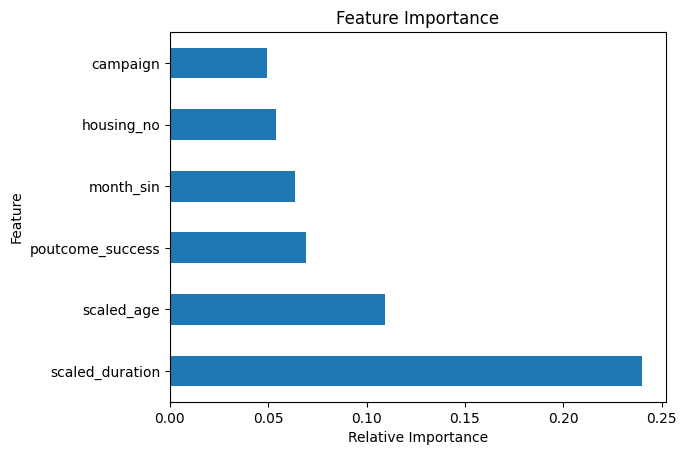

In [1791]:
# Plot the feature importances
feature_imp_sorted[:6].plot(kind="barh")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

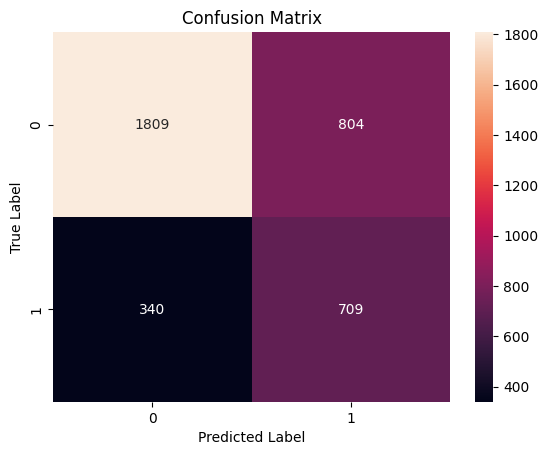

In [1792]:
# Make predictions on the test data
dt_clf_pred = dt_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, dt_clf_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

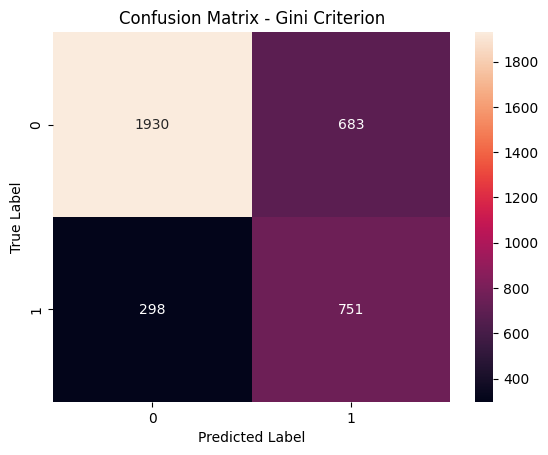

In [1793]:
# Decision Tree with Gini Criterion
# Initialize the Decision Tree Classifier with the Gini criterion
gini_dt_clf = DecisionTreeClassifier(
    criterion="gini", random_state=8, max_depth=10, min_samples_leaf=3
)

# Fit the classifier to the training data
gini_dt_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
gini_y_pred = gini_dt_clf.predict(X_test)

# Calculate the confusion matrix
gini_cm = confusion_matrix(y_test, gini_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(gini_cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gini Criterion")
plt.show()


In [1794]:
# Print the classification report
print("Classification Report - Gini Criterion")
print(classification_report(y_test, gini_y_pred))

Classification Report - Gini Criterion
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2613
           1       0.52      0.72      0.60      1049

    accuracy                           0.73      3662
   macro avg       0.69      0.73      0.70      3662
weighted avg       0.77      0.73      0.74      3662



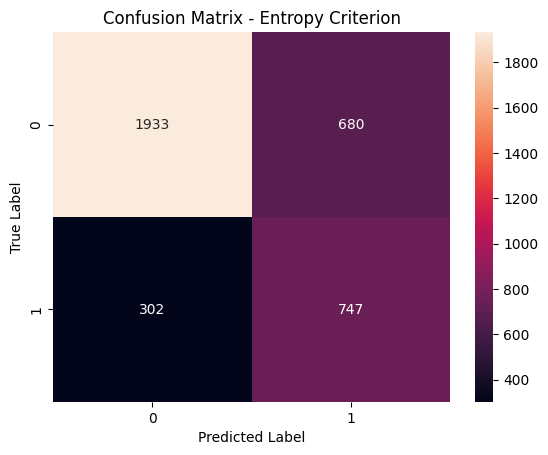

In [1795]:
# Decision Tree with Entropy Criterion
# Initialize the Decision Tree Classifier with the entropy criterion
entropy_dt_clf = DecisionTreeClassifier(criterion="entropy", random_state=8, max_depth=10, min_samples_leaf=1)

# Fit the classifier to the training data
entropy_dt_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
entropy_y_pred = entropy_dt_clf.predict(X_test)

# Calculate the confusion matrix
entropy_cm = confusion_matrix(y_test, entropy_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(entropy_cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Entropy Criterion")
plt.show()

In [1796]:
# Print the classification report
print("Classification Report - Entropy Criterion")
print(classification_report(y_test, entropy_y_pred))

Classification Report - Entropy Criterion
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      2613
           1       0.52      0.71      0.60      1049

    accuracy                           0.73      3662
   macro avg       0.69      0.73      0.70      3662
weighted avg       0.77      0.73      0.74      3662



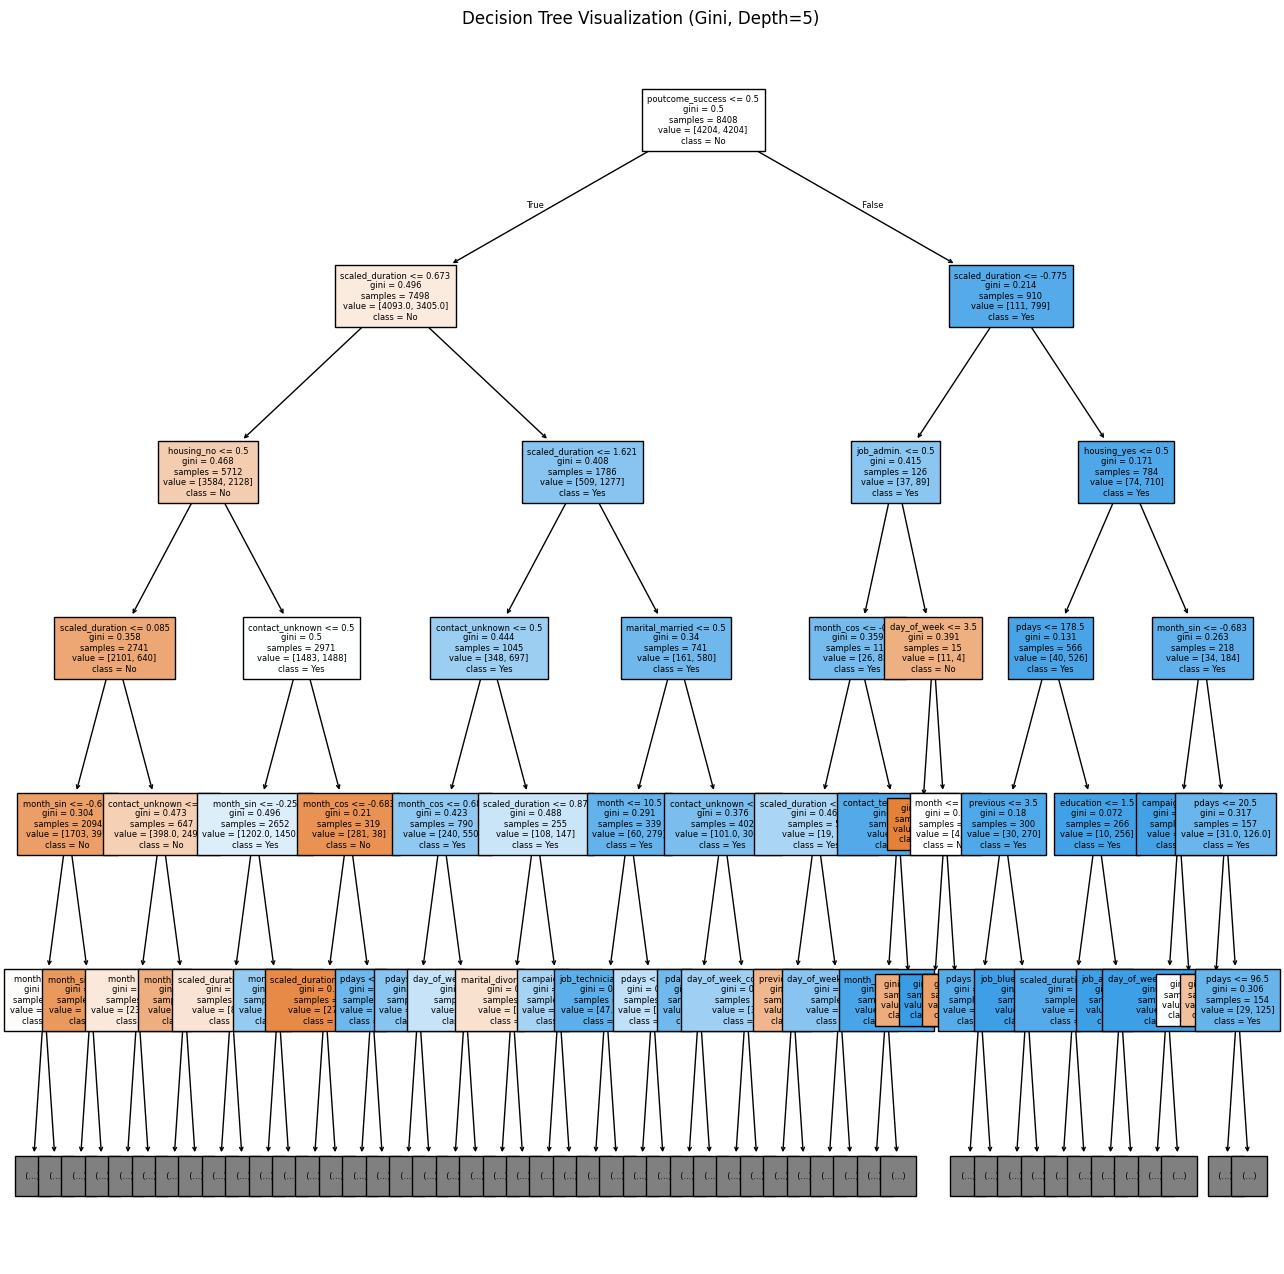

In [1797]:
# Print the decision tree visualization with depth of 5.
# Plot the decision tree (with Gini criterion)
plt.figure(figsize=(16, 16))
tree.plot_tree(
    gini_dt_clf,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    max_depth=5,
    filled=True,
    fontsize=6
)
plt.title("Decision Tree Visualization (Gini, Depth=5)")
plt.show()

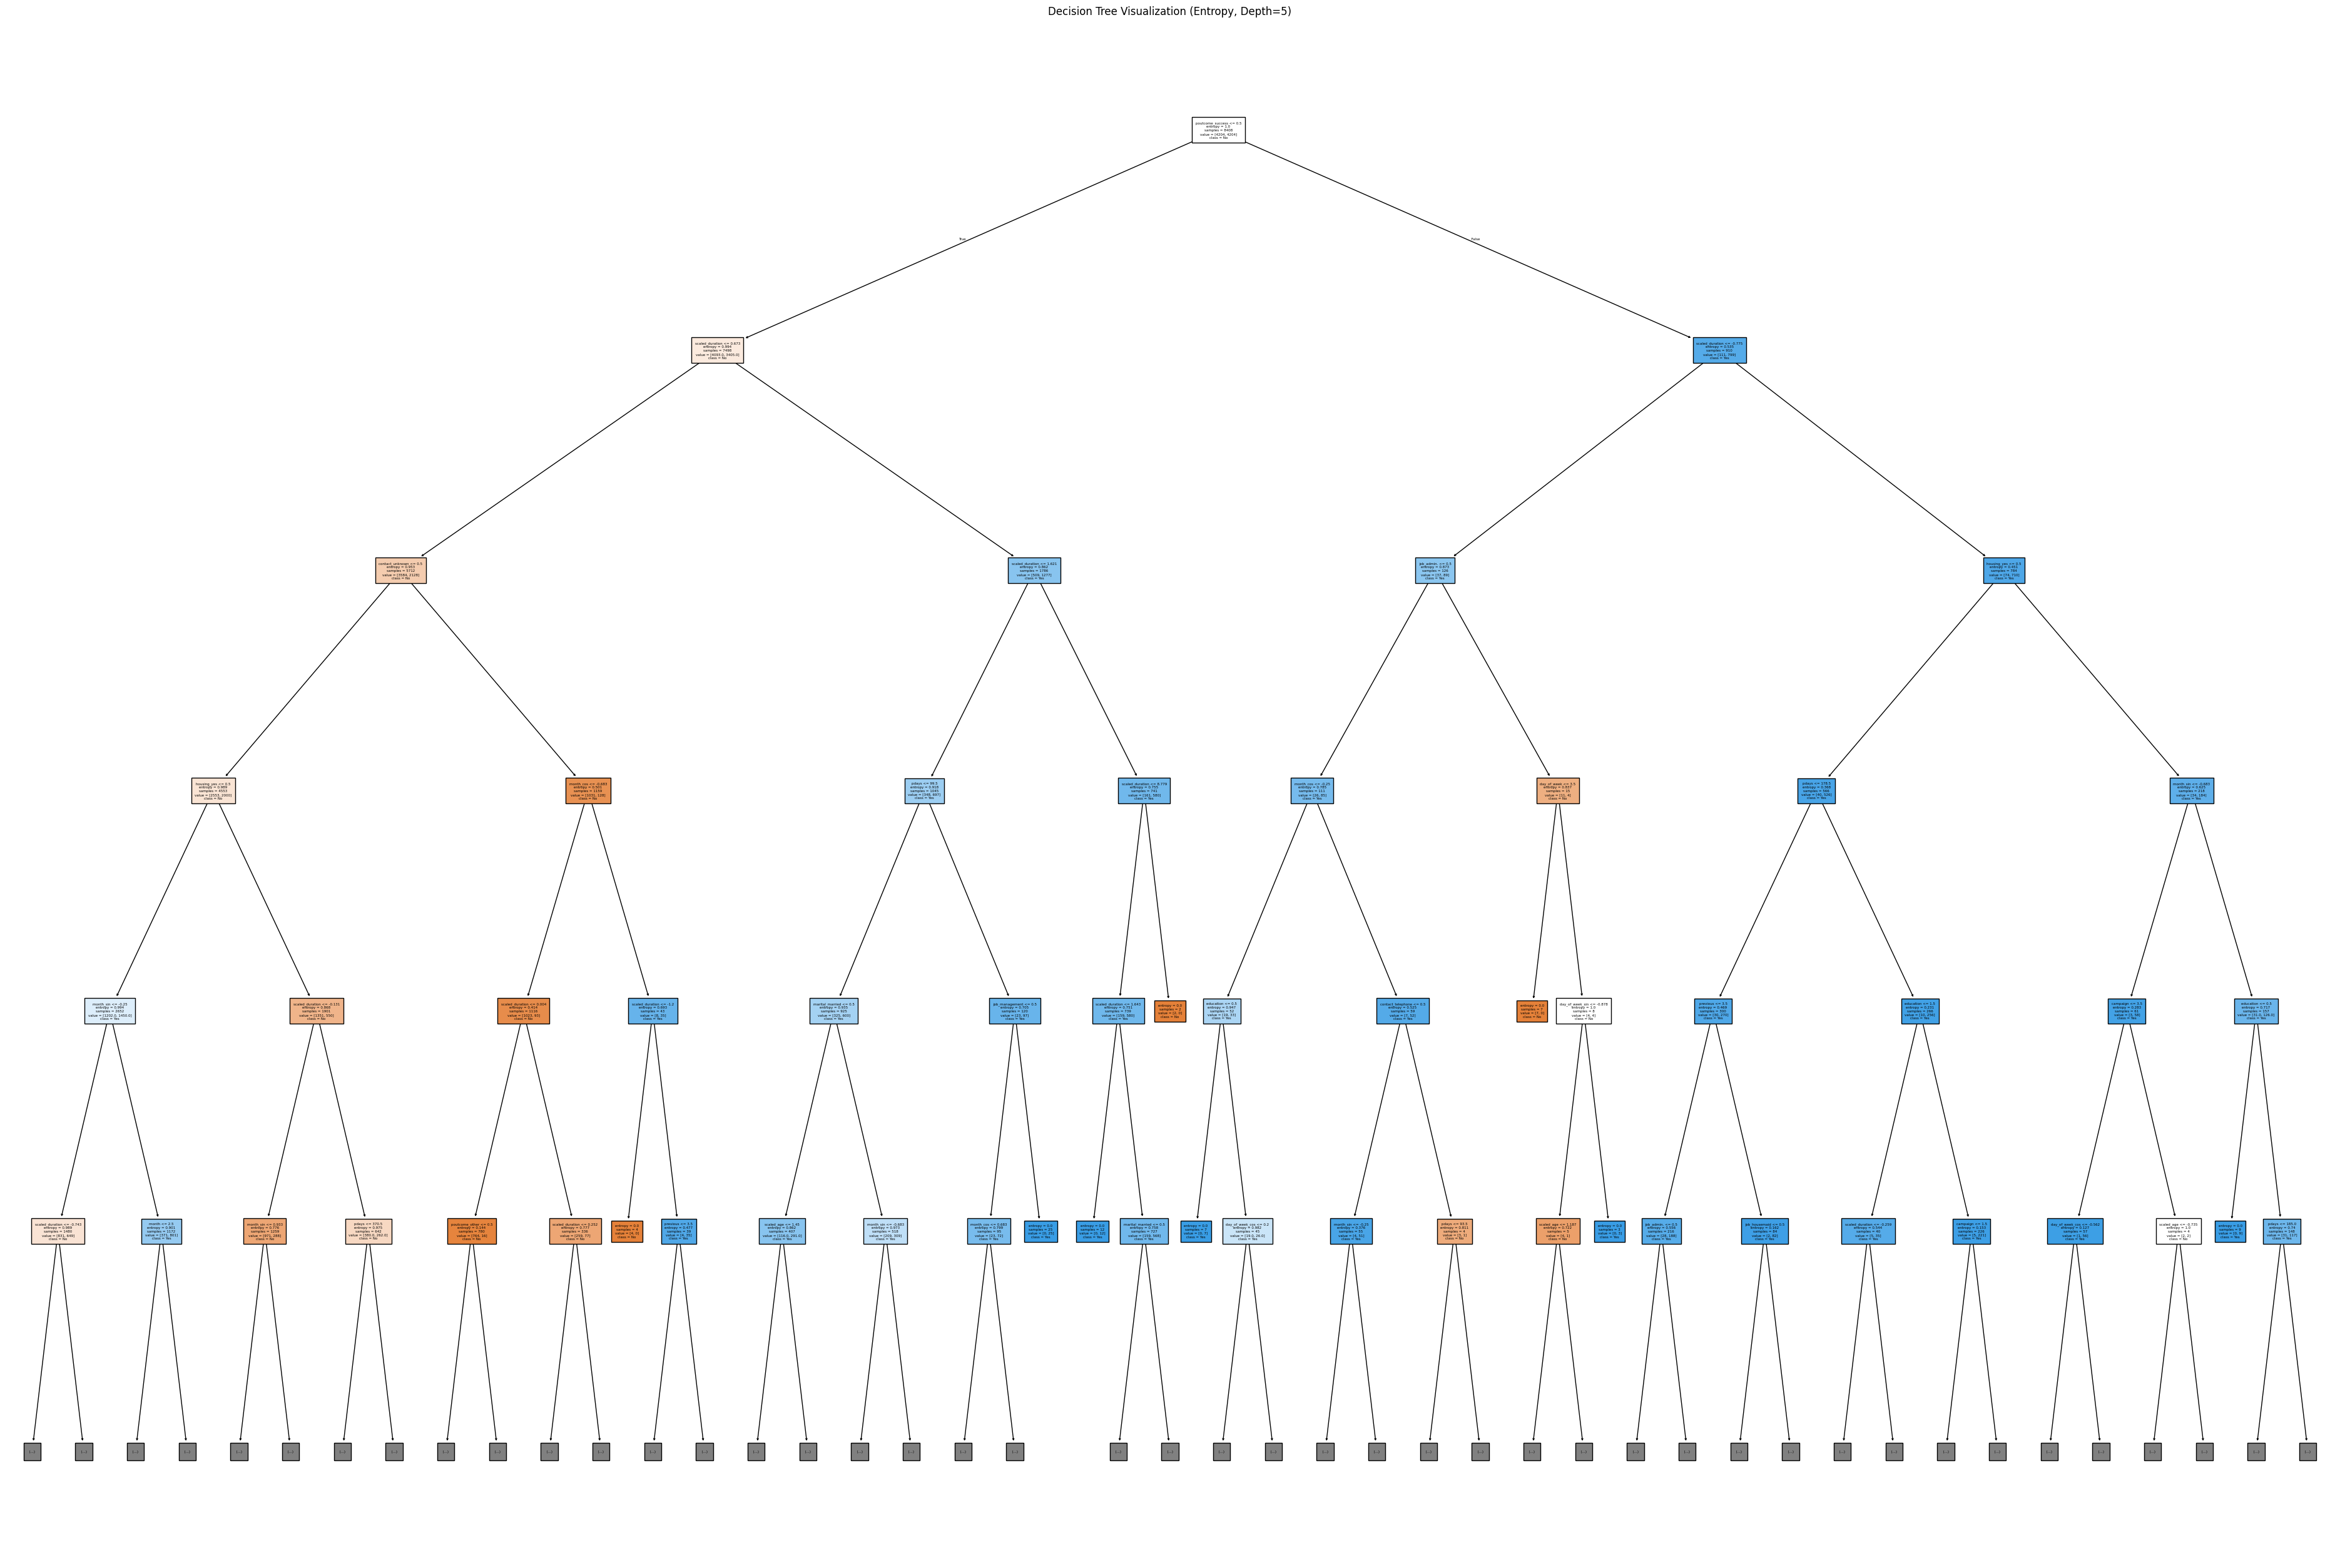

In [1798]:
# Plot the decision tree (with entropy criterion)
plt.figure(figsize=(48, 32))
tree.plot_tree(
    entropy_dt_clf,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    max_depth=5,
    filled=True,
    fontsize=4
)
plt.title("Decision Tree Visualization (Entropy, Depth=5)")
plt.show()